In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from RediCell_cupy import *
from DesignTool import *

In [2]:
d = DesignTool()
d.get_blanket_space([119, 57, 57], spacing=16e-9, wall=False)
d.add_ecoli_rod(l=1.8e-6, r=0.4e-6, barrier_type=1, space_type=1, offsety=0, thickness=2, method='const')#, offsety=1.6e-7)
d.special_space_type[d.barrier_type==1] = 2
d.barrier_type[d.special_space_type==1] = 2
d.barrier_type[d.special_space_type==0] = 3
cyt = np.where(d.special_space_type == 1)
v_cyt = len(cyt[0])
print(v_cyt)
v_cyt_b = np.random.choice(v_cyt, v_cyt//2, replace=False)
b_sel = [x[v_cyt_b] for x in cyt]
d.barrier_type[b_sel[0], b_sel[1], b_sel[2]] = 4

# Type   Space_type    Barrier_type
#    0   External      Border wall
#    1   Cytoplasm     Membrane
#    2   Membrane      Cytoplasm
#    3   None          External
#    4   None          Cytoplasm_blockers


%matplotlib inline
# d.draw3D(exclude_barrier_type=[0], exclude_space_type=[0])


Sides are [119  57  57] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [1.904e-06 9.120e-07 9.120e-07] m
Voxel [59 28 28] has a coordinate of [0. 0. 0.]
Voxel [90, 28, 28] has a coordinate of [4.96e-07 0.00e+00 0.00e+00]
Voxel [28, 28, 28] has a coordinate of [-4.96e-07  0.00e+00  0.00e+00]
Determined factor for a separating boundary as 0.7
Determined factor for a separating boundary as 0.7
Determined factor for a separating boundary as 0.7
Successfully created a E. coli rod
185908


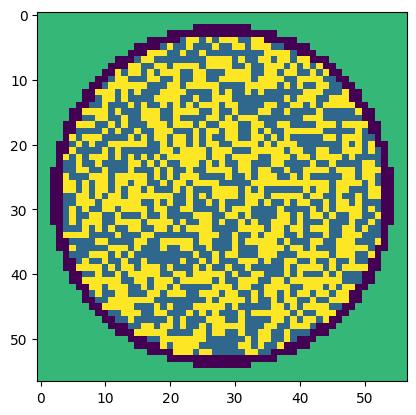

In [3]:
plt.imshow(d.barrier_type[83])

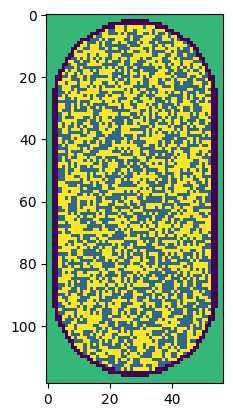

In [4]:
plt.imshow(d.barrier_type[:, 30])

In [5]:
mol_Iex =   Molecule('Iex',   diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_I =     Molecule('I',   diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_Y =     Molecule('Y',     diffusion_coefficient=0.1e-12,  observed_barrier_types=[2, 3, 4])
mol_YI =    Molecule('YI',    diffusion_coefficient=0.1e-12,  observed_barrier_types=[2, 3, 4])
mol_R2 =    Molecule('R2',    diffusion_coefficient=1e-12,    observed_barrier_types=[1, 4])
mol_R2O =   Molecule('R2O',   diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
mol_IR2 =   Molecule('IR2',   diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
mol_O =     Molecule('O',     diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
mol_IR2O =  Molecule('IR2O',  diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
mol_I2R2O = Molecule('I2R2O', diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
mol_mY =    Molecule('mY',    diffusion_coefficient=0.1e-12,  observed_barrier_types=[3, 4])
mol_I2R2 =  Molecule('I2R2',  diffusion_coefficient=1.28e-12, observed_barrier_types=[1, 4])
molset = MoleculeSet([mol_Iex, mol_I, mol_Y, mol_YI, mol_R2, mol_R2O, mol_IR2, mol_O, mol_IR2O, mol_I2R2O, mol_mY, mol_I2R2])

In [6]:
rxset = ReactionSet()
rxset.add_reaction(['R2', 'O'], ['R2O'], 2.43e6)
rxset.add_reaction(['IR2', 'O'], ['IR2O'], 1.21e6)
rxset.add_reaction(['I2R2', 'O'], ['I2R2O'], 2.43e4)
rxset.add_reaction(['R2O'], ['R2', 'O'], 6.3e-4)
rxset.add_reaction(['IR2O'], ['IR2', 'O'], 6.3e-4)
rxset.add_reaction(['I2R2O'], ['I2R2', 'O'], 3.15e-1)
rxset.add_reaction(['O'], ['mY', 'O'], 1.26e-1)
rxset.add_reaction(['mY'], ['mY', 'Y'], 4.44e-2, location=d.special_space_type==2)
rxset.add_reaction(['mY'], [], 1.11e-2, location=d.special_space_type==2)
rxset.add_reaction(['Y'], [], 2.1e-4)
rxset.add_reaction(['I', 'R2'], ['IR2'], 9.71e4)
rxset.add_reaction(['I', 'IR2'], ['I2R2'], 4.85e4)
rxset.add_reaction(['I', 'R2O'], ['IR2O'], 2.24e4)
rxset.add_reaction(['I', 'IR2O'], ['I2R2O'], 1.12e4)
rxset.add_reaction(['IR2'], ['I', 'R2'], 2e-1)
rxset.add_reaction(['I2R2'], ['I', 'IR2'], 4e-1)
rxset.add_reaction(['IR2O'], ['I', 'R2O'], 1.0)
rxset.add_reaction(['I2R2O'], ['I', 'IR2O'], 2.0)
rxset.add_reaction(['Iex'], ['I'], 2.33e-3)
rxset.add_reaction(['I'], ['Iex'], 2.33e-3)
rxset.add_reaction(['Y', 'Iex'], ['YI'], 3.03e+4)
rxset.add_reaction(['YI'], ['Y', 'Iex'], 1.2e-1)
rxset.add_reaction(['YI'], ['Y', 'I'], 1.2e+1)


In [7]:
a = RediCell_CuPy(design=d, molecule_types=molset, reaction_set=rxset, t_step=50e-6)

In [8]:
a_supply_matrix = cp.zeros(a.true_sides)
# a_supply_matrix[(a.special_space_type == 0) * (a.barrier_type == -1)] = 1
a_supply_matrix[:, :, [0, -1]] = 1
a_supply_matrix[:, [0, -1], :] = 1
a_supply_matrix[[0, -1], :, :] = 1

a.add_external_conditions(a_supply_matrix, mol_Iex, 5)
a.show_external_conditions()

Maintain 5 micromolar of Iex within a space of 32706 voxels (403 molecules)


In [9]:
a.mol_to_id

{'Iex': 0,
 'I': 1,
 'Y': 2,
 'YI': 3,
 'R2': 4,
 'R2O': 5,
 'IR2': 6,
 'O': 7,
 'IR2O': 8,
 'I2R2O': 9,
 'mY': 10,
 'I2R2': 11}

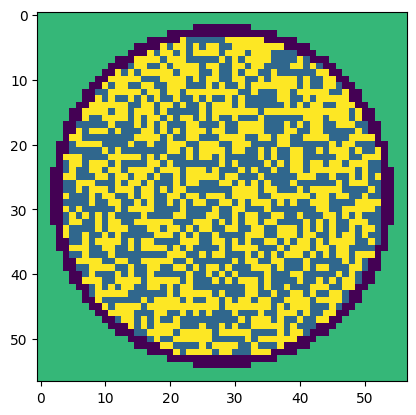

In [10]:
plt.imshow(a.barrier_type[80].get())

In [11]:
a.partition()

Reagent list: [[4, 7], [6, 7], [11, 7], [5], [8], [9], [7], [10], [10], [2], [1, 4], [1, 6], [1, 5], [1, 8], [6], [11], [8], [9], [0], [1], [2, 0], [3], [3]]
Action list:
Diffusion of Iex (6 directions)
Diffusion of I (6 directions)
Diffusion of Y (6 directions)
Diffusion of YI (6 directions)
Diffusion of R2 (6 directions)
Diffusion of R2O (6 directions)
Diffusion of IR2 (6 directions)
Diffusion of O (6 directions)
Diffusion of IR2O (6 directions)
Diffusion of I2R2O (6 directions)
Diffusion of mY (6 directions)
Diffusion of I2R2 (6 directions)
Reaction: reagent ['R2', 'O'] -> product ['R2O']
Reaction: reagent ['IR2', 'O'] -> product ['IR2O']
Reaction: reagent ['I2R2', 'O'] -> product ['I2R2O']
Reaction: reagent ['R2O'] -> product ['R2', 'O']
Reaction: reagent ['IR2O'] -> product ['IR2', 'O']
Reaction: reagent ['I2R2O'] -> product ['I2R2', 'O']
Reaction: reagent ['O'] -> product ['mY', 'O']
Reaction: reagent ['mY'] -> product ['mY', 'Y']
Reaction: reagent ['mY'] -> product []
Reaction: 

In [12]:
a.configure_barrier()

In [13]:
a.voxel_matrix.shape

(12, 119, 57, 57)

In [14]:
# Initial conditions
# Type   Space_type    Barrier_type
#    0   External      Border wall
#    1   Cytoplasm     Membrane
#    2   Membrane      Cytoplasm
#    3   None          External
#    4   None          Cytoplasm_blockers
a.add_molecules((a.special_space_type == 1) & (a.barrier_type != 4), 'O', count=1)
a.add_molecules((a.special_space_type == 1) & (a.barrier_type != 4), 'R2', count=9)
a.add_molecules(a.special_space_type == 2, 'Y', count=30)
a.add_molecules(a.special_space_type > -1, 'Iex', uM=5)
a.add_molecules(a.special_space_type > -1, 'I', uM=5)

Add 1 O molecules
Add 9 R2 molecules
Add 30 Y molecules
Add 4769 Iex molecules (5.00 uM)
Add 4769 I molecules (5.00 uM)


In [15]:
a.one_per_voxel_equal_um

405.3472106923459

In [16]:
a.voxel_matrix[a.mol_to_id['R2']].sum()

array(9., dtype=float32)

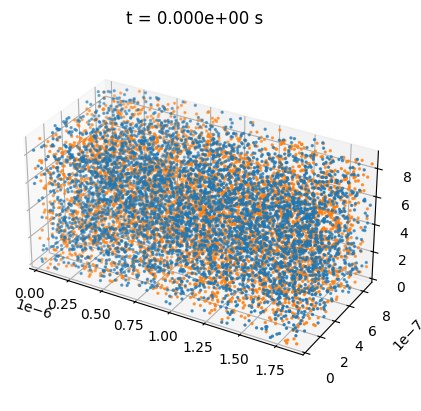

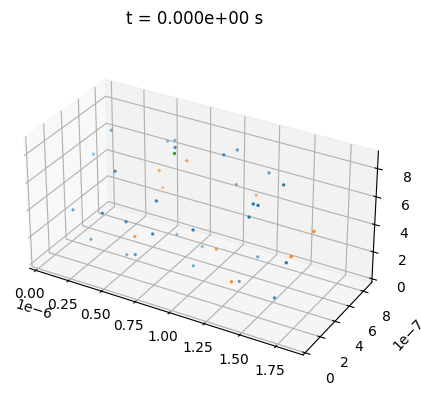

In [17]:
a.plot3D(['Iex', 'I'], wall=False)
a.plot3D(['Y', 'R2', 'O'], wall=False)

In [18]:
a.maintain_external_conditions()

In [19]:
a.mesh[0].shape

(119, 57, 57)

In [20]:
a.reaction_vector_list[0]

array([ 0,  0,  0,  0, -1,  1,  0, -1,  0,  0,  0,  0])

In [21]:
a.reaction_matrix_list[2].shape

(12, 119, 57, 57)

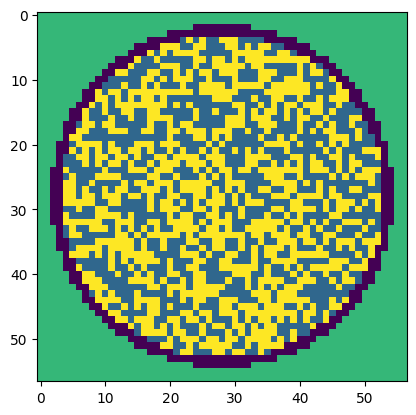

In [22]:
plt.imshow(a.barrier_type[50].get())

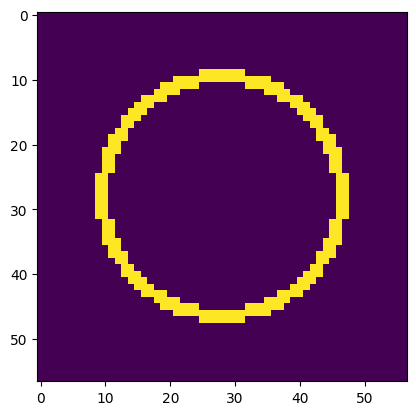

In [23]:
plt.imshow(a.not_barrier_matrix_up[2, 10].get())

In [24]:
a.mol_to_id

{'Iex': 0,
 'I': 1,
 'Y': 2,
 'YI': 3,
 'R2': 4,
 'R2O': 5,
 'IR2': 6,
 'O': 7,
 'IR2O': 8,
 'I2R2O': 9,
 'mY': 10,
 'I2R2': 11}

In [25]:
a.voxel_matrix[0].sum()

array(4777., dtype=float32)

In [26]:
a.diffusion_vector

[29999.999999999996,
 29999.999999999996,
 2343.75,
 2343.75,
 23437.5,
 29999.999999999996,
 29999.999999999996,
 29999.999999999996,
 29999.999999999996,
 29999.999999999996,
 2343.75,
 29999.999999999996]

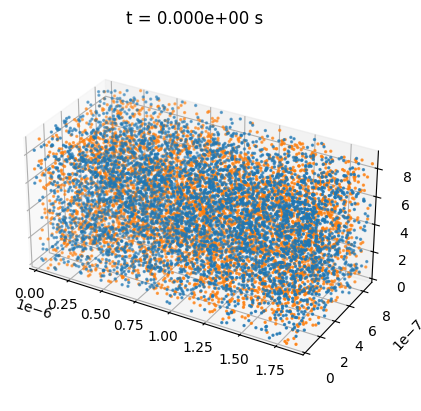

In [27]:
a.plot(['Iex', 'I'], wall=False)

In [28]:
a.determine_maximum_timestep()

Max time step is 5.00e-05 s (max 1.0 particles in voxel)


array(5.e-05, dtype=float32)

In [30]:
a.simulate(100000, t_step=5e-5,
           checkpoint_every=None,
           traj_every=None, log_every=100)
# a.plot(['Iex', 'Iin'], wall=False)

0.0% |          |26/100001 [00:00<06:29, 256.89it/s, Act Mol=8 ( Iex I Y R2 IR2 O mY I2R2 ), Act Rxn=14]

Simulate 100001 steps


3.7% |▎         |3744/100001 [00:14<06:14, 257.27it/s, Act Mol=8 ( Iex I Y R2 IR2 O mY I2R2 ), Act Rxn=14]


KeyboardInterrupt: 

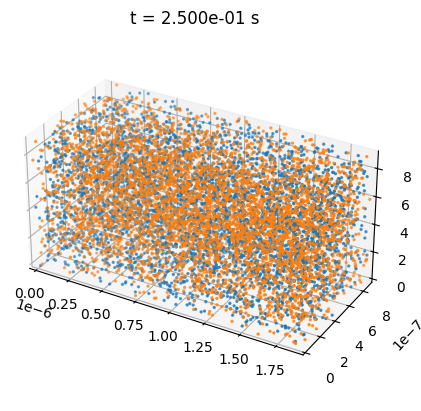

In [188]:
a.plot(['Iex','I', 'Y', 'YI'], wall=False)

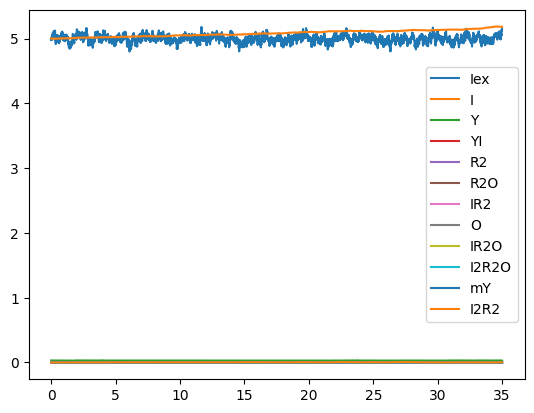

In [30]:
plt.plot(a.t_trace, np.array([x.astype(cp.float32).get() for x in a.conc_trace]) * a.one_per_voxel_equal_um / np.prod(np.array(a.voxel_matrix[0].shape)), label=a.mol_to_id)
plt.legend()
# plt.yticks(range(7))
# plt.yscale('log')

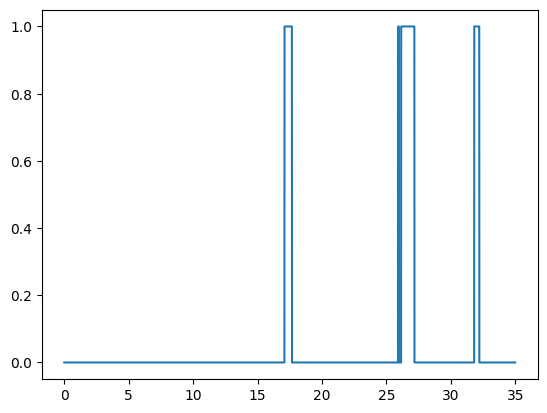

In [35]:
plt.plot(a.t_trace, cp.array(a.conc_trace)[:, a.mol_to_id['IR2O']].get())

In [44]:
a.voxel_matrix[1].astype(cp.float32).get().sum()

21040.0

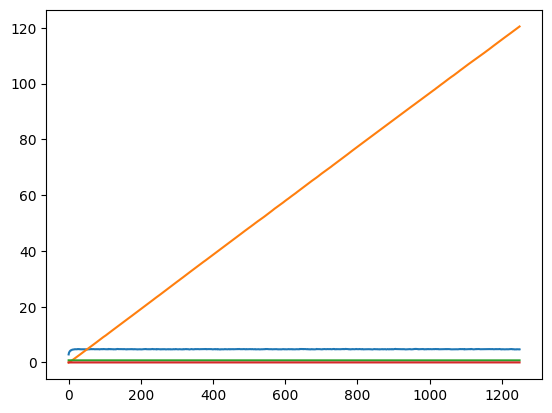

In [33]:
plt.plot(b.t_trace, np.array([x.astype(cp.float32).get() for x in b.conc_trace]) * b.one_per_voxel_equal_um / np.prod(np.array(b.voxel_matrix[0].shape) - 2))
# plt.yticks(range(7))
# plt.yscale('log')

In [93]:
a.one_per_voxel_equal_um

405.3472106923459

In [148]:
a.one_per_voxel_equal_um * float(a.voxel_matrix[a.mol_to_id['Iex']].sum()) / np.prod(np.array(a.voxel_matrix[0].shape))

5.794225421920151

In [26]:
np.prod(np.array(a.voxel_matrix[0].shape) - 2)

524288